<a href="https://colab.research.google.com/github/pankajr141/experiments/blob/master/Experiments/covid_facemask_and_social_distance/facemask_using_mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset Preparation

We will be downloading the dataset from https://www.kaggle.com/wobotintelligence/face-mask-detection-dataset

This dataset contains 20 different labels. 

1. mask_colorful 
2. mask_surgical 
3. face_no_mask 
4. face_with_mask_incorrect 
5. face_with_mask 
6. face_other_covering 
7. scarf_bandanaz
8. balaclava_ski_mask 
9. face_shield 
10. Other 
11. gas_mask 
12. Turban 
13. Helmet 
14. Sunglasses 
15. Eyeglasses 
16. hair_net 
17. Hat 
18. Goggles 
19. hood 
20. hijab_niqab

In [ ]:
''' Essential '''
import sys
import logging as log
import matplotlib.pyplot as plt
import os
import cv2
import json
import pandas as pd
import numpy as np
import shutil

log.basicConfig(format="[ %(levelname)s ] %(message)s", level=log.INFO, stream=sys.stdout)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!kaggle datasets download -d ivandanilovich/medical-masks-dataset-images-tfrecords -p dataset
!kaggle datasets download -d abdelaliezzyn/medical-masks -p dataset

 96% 224M/234M [00:02<00:00, 40.3MB/s]
100% 234M/234M [00:03<00:00, 81.0MB/s]
medical-masks.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# !unzip dataset/medical-masks-dataset-images-tfrecords.zip -d dataset/medical-masks-dataset
# !rm dataset/medical-masks-dataset-images-tfrecords.zip
# !unzip dataset/medical-masks.zip -d dataset/medical-masks
# !rm dataset/medical-masks.zip

In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   48G   18G  73% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
/dev/sda1        75G   55G   21G  73% /opt/bin
tmpfs           6.4G   16K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G   14G  1.6G  90% /content/drive


In [ ]:
''' Essential '''

''' Download Datasets from kaggle https://www.kaggle.com/general/74235'''
!mkdir ~/.kaggle
!mkdir -p "/content/drive/My Drive/datasets/facemask"
!mkdir dataset

!pip install -q kaggle

!cp '/content/drive/My Drive/Kaggle/kaggle.json' ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list

''' Uncomment commented line if executing for first time, 
it will copy the dataset in google drive, so that we dont need to download it every time from kaggle'''

# print("Downloading dataset from Kaggle ")
# !kaggle datasets download -d wobotintelligence/face-mask-detection-dataset -p dataset
#!cp dataset/face-mask-detection-dataset.zip '/content/drive/My Drive/datasets/facemask/face-mask-detection-dataset.zip'

import time
starttime = time.time()
!cp -R "/content/drive/My Drive/datasets/facemask/facemask-detection-dataset.zip" dataset/facemask-detection-dataset.zip
print("Total time:", time.time() - starttime)

Total time: 214.0025601387024


In [ ]:
''' First Time only '''
!unzip dataset/facemask/face-mask-detection-dataset.zip
!unzip dataset/facemask/labeled.zip

In [ ]:
!git clone https://github.com/chandrikadeb7/Face-Mask-Detection.git
!cp Face-Mask-Detection/dataset/with_mask/* dataset/facemask/labeled/face_with_mask
!cp Face-Mask-Detection/dataset/without_mask/* dataset/facemask/labeled/face_no_mask

In [ ]:
# !cp /content/dataset/_labeled_tmp/mask/* /content/dataset/facemask/labeled/face_with_mask
# !cp /content/dataset/_labeled_tmp/none/* /content/dataset/facemask/labeled/face_no_mask
# !cp /content/dataset/_labeled_tmp/poor/* /content/dataset/facemask/labeled/face_with_mask_incorrect
# !ls /content/dataset/facemask/labeled/face_with_mask | wc -l 
# !ls /content/dataset/facemask/labeled/face_no_mask | wc -l 
# !ls /content/dataset/facemask/labeled/face_with_mask_incorrect | wc -l 
# !ls /content/dataset/_labeled_tmp/poor/ | wc -l

10250
4289
296
147


In [ ]:
!zip -r dataset/facemask/labeled.zip dataset/facemask/labeled/
# !cp dataset/facemask/labeled.zip "/content/drive/My Drive/datasets/facemask/labeled.zip"

In [ ]:
!ls -lh  "/content/drive/My Drive/datasets/facemask"

total 4.5G
drwx------ 2 root root 4.0K Sep 11 17:31 face_detector
-rw------- 1 root root 2.5G Sep 11 13:28 face-mask-detection-dataset.zip
-rw------- 1 root root  11M Sep 16 12:09 face_mask.tf
-rw------- 1 root root  24M Sep 18 17:25 face_mask_v2.tf
-rw------- 1 root root 2.0G Sep 18 20:17 labeled.zip


### Summary statistics

Lets found our labels statistics

In [ ]:
''' Essential '''

import os
import json
from collections import defaultdict
import pandas as pd

image_dir = "Medical mask/Medical mask/Medical Mask/images"
image_files = [os.path.join(image_dir, x) for x in os.listdir(image_dir)]
print("Total Files:", len(image_files))

annotatations_dir = "Medical mask/Medical mask/Medical Mask/annotations"
annotatations_files = [os.path.join(annotatations_dir, x) for x in os.listdir(annotatations_dir)]
print("Total Files:", len(annotatations_files))

def summary_annotatation(filepath):
    json_data = json.load(open(filepath))
    classes = [ x['classname'] for x in json_data['Annotations']]
    # if len(classes) > 1:
    #      print(filepath, len(classes))
    return classes

classes_dict = defaultdict(int)
for annotatations_file in annotatations_files:
    for classname in summary_annotatation(annotatations_file):
        classes_dict[classname] += 1

#pd.DataFrame(dict(classes_dict))
dict(classes_dict)

Total Files: 6024
Total Files: 4326


{'balaclava_ski_mask': 134,
 'eyeglasses': 914,
 'face_no_mask': 1569,
 'face_other_covering': 1372,
 'face_shield': 160,
 'face_with_mask': 4180,
 'face_with_mask_incorrect': 150,
 'gas_mask': 55,
 'goggles': 192,
 'hair_net': 287,
 'hat': 823,
 'helmet': 187,
 'hijab_niqab': 173,
 'hood': 159,
 'mask_colorful': 1876,
 'mask_surgical': 2430,
 'other': 39,
 'scarf_bandana': 260,
 'sunglasses': 358,
 'turban': 94}

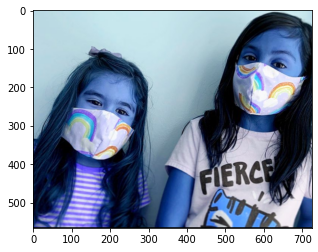

In [ ]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread("Medical mask/Medical mask/Medical Mask/images/2756.png")
plt.imshow(img)
plt.show()

### Generate Dataset - 
Generate dataset by cropping our source images using hackathon

In [ ]:
''' Not Essential '''
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Input
import numpy as np

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.join("dataset/facemask/face_detector", "deploy.prototxt")
weightsPath = os.path.join("dataset/facemask/face_detector", "res10_300x300_ssd_iter_140000.caffemodel")
net = cv2.dnn.readNet(prototxtPath, weightsPath)

def detect_face(img):
    (h, w) = img.shape[:2]

    # construct a blob from the image
    blob = cv2.dnn.blobFromImage(img, 1.0, (300, 300), (104.0, 177.0, 123.0))
    print("Img Shape:", img.shape, "Blob shape:", blob.shape)

    # pass the blob through the network and obtain the face detections
    print("[INFO] computing face detections...")
    net.setInput(blob)
    detections = net.forward()
    
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence < 0.50:
            continue
        print(confidence)

        # compute the (x, y)-coordinates of the bounding box for the object
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        # ensure the bounding boxes fall within the dimensions of
        # the frame
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

        # extract the face ROI, convert it from BGR to RGB channel
        # ordering, resize it to 224x224, and preprocess it
        face = img[startY:endY, startX:endX]
        yield face

[INFO] loading face detector model...


### Dataset generater - v1

In [ ]:
''' Medical Mask v 1'''

import cv2
import matplotlib.pyplot as plt
# from mtcnn.mtcnn import MTCNN

# print(annotatations_files[0:2])

def generate_dataset(fileid, display=True):
    color_dict = {'face_with_mask': 1, 'mask_colorful': 10}
    img = cv2.imread(f"dataset/Medical mask/Medical mask/Medical Mask/images/{fileid}")
    annotations = json.load(open(f"dataset/Medical mask/Medical mask/Medical Mask/annotations/{fileid}.json"))

    # img_crops = list(detect_face(img))
    # print("face detected:", len(img_crops))
    # for img_crop in img_crops:        
    #     # cv2.imwrite(file_output_path, img_crop)
    #     if img_crop.shape[0] < 50 or img_crop.shape[1] < 50:
    #         continue
    #     print("THIS IS TO SHOW")
    #     plt.imshow(img_crop)
    #     plt.show()

    # detector=MTCNN()
    # face=detector.detect_faces(img)
    # for face in face:
    #       bounding_box=face['box']
    #       cv2.rectangle(img,
    #             (bounding_box[0], bounding_box[1]),
    #             (bounding_box[0] + bounding_box[2], bounding_box[1] + bounding_box[3]),
    #             (0,155,255),
    #             10)
    # plt.imshow(img)
    # plt.show()
            
    for i, annotation in enumerate(annotations['Annotations']):
        #print(annotation)
        x1, y1, x2, y2 = annotation['BoundingBox']
        classname = annotation['classname']

        # if not classname in ['face_with_mask', 'face_no_mask', 'face_with_mask_incorrect']:
        #     continue
        dir_l = os.path.join(dir_labels, classname)
        if not os.path.exists(dir_l):
            os.makedirs(dir_l)
        
        file_output_path = os.path.join(dir_l, str(i) + "_" + fileid + ".png")
        color = color_dict.get(classname, 0)

        img = cv2.rectangle(img, (x1, y1), (x2, y2), color, 3) 
        img_crop = img[y1:y2, x1: x2, :]
        # cv2.imwrite(file_output_path, img_crop)

        # plt.imshow(img_crop)
        # plt.show()
        
    if display:
        plt.imshow(img)
        plt.show()

dir_labels = "dataset/_labeled_tmp"
if not os.path.exists(dir_labels):
    os.makedirs(dir_labels)

print(annotatations_files[0])

# fileid = "2756.png"
for annotatations_file in annotatations_files[4:]:
    try:
        fileid = os.path.basename(annotatations_file).replace(".json", "")
        generate_dataset(fileid, display=False)
    except Exception as err:
        print(err, annotatations_file)
    break

Medical mask/Medical mask/Medical Mask/annotations/3808.png.json


### Dataset Generator - medical-masks-dataset (268 MB)

In [ ]:
''' Medical Mask v 1'''

import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
# from mtcnn.mtcnn import MTCNN

# print(annotatations_files[0:2])
def generate_dataset(label_file, display=True):
    img_file = label_file.replace('labels', 'images').replace('xml', 'jpg')
    color_dict = {'mask': (0, 255, 0), 'none': (255, 0, 0)}
    img = cv2.imread(img_file)
    root = ET.parse(label_file).getroot()
    for i, type_tag in enumerate(root.findall('object')):
        try:
            classname, x1, x2, y1, y2 = None, None, None, None, None
            for child in type_tag:
                if child.tag == 'name':
                    classname = child.text
                elif child.tag == "bndbox":
                    for subchild in child:
                        if subchild.tag == "xmin":
                              x1 = int(subchild.text)
                        elif subchild.tag == "xmax":
                              x2 = int(subchild.text)
                        elif subchild.tag == "ymin":
                              y1 = int(subchild.text)
                        elif subchild.tag == "ymax":
                              y2 = int(subchild.text)
            if x1 > x2:
                x1, x2 = x2, x1
            if y1 > y2:
                y1, y2 = y2, y1

            b = 20

            x1, x2, y1, y2 = x1 - b, x2 + b, y1 - b, y2
            x1 = max(0, x1)
            y1 = max(0, y1)
            dir_l = os.path.join(dir_labels, classname)
            if not os.path.exists(dir_l):
                os.makedirs(dir_l)

            file_output_path = os.path.join(dir_l, str(i) + "_" + os.path.basename(img_file) + ".png")
            color = color_dict.get(classname, (0, 0, 0))

            #img = cv2.rectangle(img, (x1, y1), (x2, y2), color, 3) 
            img_crop = img[y1:y2, x1: x2, :]
            cv2.imwrite(file_output_path, img_crop)
        except Exception as err:
            print(label_file)
            print(img.shape, x1, x2, y1, y2)
            print(err, print(img_crop.shape))

    #     plt.imshow(img_crop)
    #     plt.show()
        
    # if display:
    #     plt.imshow(img)
    #     plt.show()

dir_labels = "dataset/_labeled_tmp"
if not os.path.exists(dir_labels):
    os.makedirs(dir_labels)

dataset_dir = "/content/dataset/medical-masks-dataset/medical-masks-dataset"
labels_files = [os.path.join(dataset_dir, 'labels', x) for x in os.listdir(os.path.join(dataset_dir, 'labels'))]

# fileid = "2756.png"
import traceback
print(len(labels_files))
for labels_file in labels_files:
    try:
        # if not '249_mask.xml' in labels_file:
        #     continue 
        generate_dataset(labels_file, display=True)
    except Exception as err:
        print(err, labels_file)
        #traceback.print_exc()

1148


In [ ]:
!ls /content/dataset/_labeled_tmp/mask | wc -l
!ls /content/dataset/_labeled_tmp/none | wc -l
!ls /content/dataset/_labeled_tmp/poor | wc -l
!rm -rf /content/dataset/_labeled_tmp

ls: cannot access '/content/dataset/_labeled_tmp/mask': No such file or directory
0
516
ls: cannot access '/content/dataset/_labeled_tmp/poor': No such file or directory
0


### Dataset medical-masks [5.2 GB] -- Dataset Not good

In [ ]:
''' Medical Mask v 1'''

import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
# from mtcnn.mtcnn import MTCNN

# print(annotatations_files[0:2])
def generate_dataset(label_file, display=True):
    img_file = label_file.replace('annotations', 'images').replace('xml', 'png')
    color_dict = {'mask': (0, 255, 0), 'none': (255, 0, 0)}
    img = cv2.imread(img_file)
    root = ET.parse(label_file).getroot()
    for i, type_tag in enumerate(root.findall('object')):
        try:
            classname, x1, x2, y1, y2 = None, None, None, None, None
            for child in type_tag:
                if child.tag == 'name':
                    classname = child.text
                elif child.tag == "bndbox":
                    for subchild in child:
                        if subchild.tag == "xmin":
                              x1 = int(subchild.text)
                        elif subchild.tag == "xmax":
                              x2 = int(subchild.text)
                        elif subchild.tag == "ymin":
                              y1 = int(subchild.text)
                        elif subchild.tag == "ymax":
                              y2 = int(subchild.text)
            # print(classname, x1, x2, y1, y2, img.shape)
            if x1 > x2:
                x1, x2 = x2, x1
            if y1 > y2:
                y1, y2 = y2, y1

            b = 20

            x1, x2, y1, y2 = x1 - b, x2 + b, y1 - b, y2
            x1 = max(0, x1)
            y1 = max(0, y1)
            dir_l = os.path.join(dir_labels, classname)
            if not os.path.exists(dir_l):
                os.makedirs(dir_l)

            file_output_path = os.path.join(dir_l, str(i) + "_" + os.path.basename(img_file) + ".png")
            color = color_dict.get(classname, (0, 0, 0))

            # img = cv2.rectangle(img, (x1, y1), (x2, y2), color, 3) 
            img_crop = img[y1:y2, x1: x2, :]
            cv2.imwrite(file_output_path, img_crop)
        except Exception as err:
            print(label_file)
            print(img.shape, x1, x2, y1, y2)
            print(err, print(img_crop.shape))

        # plt.imshow(img_crop)
        # plt.show()
        
    # if display:
    #     plt.imshow(img)
    #     plt.show()

dir_labels = "dataset/_labeled_tmp"
if not os.path.exists(dir_labels):
    os.makedirs(dir_labels)

dataset_dir = "/content/dataset/medical-masks/medical_masks/train"
labels_files = [os.path.join(dataset_dir, 'annotations', x) for x in os.listdir(os.path.join(dataset_dir, 'annotations'))]

# fileid = "2756.png"
import traceback
print(len(labels_files))
for labels_file in labels_files[100:400]:
    try:
        # if not '249_mask.xml' in labels_file:
        #     continue 
        generate_dataset(labels_file, display=True)
    except Exception as err:
        print(err, labels_file)
        traceback.print_exc()

7782


## Train model

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit 
from tensorflow.keras.utils import to_categorical

''' Lets Load and generate datasets '''
dir_labels = "dataset/facemask/labeled"
labels = os.listdir(dir_labels)
labels = list(filter(lambda x: x not in ['other', 'gas_mask', 'goggles', 'eyeglasses', 'sunglasses', 'hat', 'helmet', 'hair_net'], labels))

labels = ['face_with_mask', 'face_no_mask', 'face_with_mask_incorrect']
print(labels)

def generate_dataset(labels):
    x = []
    y = []
    for cntr, label in enumerate(labels):
        dir_l = os.path.join(dir_labels, label)
        filepaths = [os.path.join(dir_l, x) for x in os.listdir(dir_l)]
        
        print("Reading %s: %d files" % (label, len(filepaths)))
        
        for i, filepath in enumerate(filepaths):
            img = cv2.imread(filepath)
            img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_NEAREST) 

            x.append(img)
            y.append(cntr)
            if i > 400:
                break
    return np.array(x), np.array(y)


X, Y = generate_dataset(labels)
Y = to_categorical(Y, len(labels))
print(X.shape, Y.shape)

# labels = ['mask', 'no_mask', 'incorrect']


def getTrainHoldoutSplit(df, dfLabel, holdoutSize=0.15):
    dfHoldOut = None
    dfHoldOutLabel = None
    cv_pre = StratifiedShuffleSplit(1, test_size=holdoutSize, random_state=0)

    for train_index, test_index in cv_pre.split(X, Y):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        df, dfLabel = x_train, y_train
        dfHoldOut, dfHoldOutLabel = x_test, y_test
    print("==================== Data Set ==================================")
    print("Holdout Set => ", dfHoldOut.shape)
    print("Train Set => ", df.shape)
    print("==================== Data Set ==================================")
    return df, dfLabel, dfHoldOut, dfHoldOutLabel

X_train, Y_train, X_test, Y_test = getTrainHoldoutSplit(X, Y, holdoutSize=0.20)
print(X_train.shape, Y_train.shape)
# print(list(set(np.argmax(Y_train, axis=1).tolist())))
# assert(len(list(set(np.argmax(Y_test, axis=1).tolist()))) == len(labels))

['face_with_mask', 'face_no_mask', 'face_with_mask_incorrect']
Reading face_with_mask: 10250 files
Reading face_no_mask: 4289 files
Reading face_with_mask_incorrect: 296 files
(1100, 224, 224, 3) (1100, 3)
==================== Data Set ==================================
Holdout Set =>  (220, 224, 224, 3)
Train Set =>  (880, 224, 224, 3)
==================== Data Set ==================================
(880, 224, 224, 3) (880, 3)


In [ ]:
''' Using Mobile net to pin point person mask location. '''
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

img_augumenter = ImageDataGenerator(rotation_range=15, zoom_range=0.15, width_shift_range=0.2,
	height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# We will use transfer learning
x = AveragePooling2D(pool_size=(3, 3))(base_model.output)
x = Flatten(name="flatten")(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.4)(x)

# x = Dense(64, activation="relu")(x)
# x = Dropout(0.2)(x)

x = Dense(len(labels), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=x)

''' Freeze base model layers '''
flag = False
for layer in base_model.layers:
    if layer.name.startswith('block_16'):
        flag = True
    layer.trainable = flag
    # print(layer.name, layer.trainable)

lr = 0.0001
epochs = 40
opt = Adam(lr=lr, decay=lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
print("[INFO] training head...")
bs = 32
# H = model.fit(X_train, Y_train, 
#               steps_per_epoch=len(X_train)/bs,
#               validation_data=(X_test, Y_test),	epochs=epochs)

H = model.fit(img_augumenter.flow(X_train, Y_train, batch_size=bs), 
              steps_per_epoch=len(X_train)/bs,
              validation_data=(X_test, Y_test),	epochs=epochs)

# make predictions on the testing set
print("[INFO] evaluating network...")

predictions = model.predict(X_test, batch_size=bs)
print(Y_test.shape, predictions.shape)
predictions = np.argmax(predictions, axis=1)

# print(predictions)

# show a nicely formatted classification report
print(classification_report(Y_test.argmax(axis=1), predictions,	target_names=labels))

# serialize the model to disk
log.info("Saving mask detector model...")
model.save("/content/drive/My Drive/datasets/facemask/face_mask_v3.tf", save_format="h5")

# shutil.copy("face_mask_v3.tf", "/content/drive/My Drive/datasets/facemask/face_mask_v3.tf")

[ WARNING ] `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
[INFO] training head...
Epoch 1/40
28/27 [==============================] - 12s 433ms/step - loss: 0.7707 - accuracy: 0.4500 - val_loss: 0.7523 - val_accuracy: 0.3818
Epoch 2/40
28/27 [==============================] - 11s 399ms/step - loss: 0.5789 - accuracy: 0.5443 - val_loss: 0.6253 - val_accuracy: 0.4500
Epoch 3/40
28/27 [==============================] - 11s 391ms/step - loss: 0.5165 - accuracy: 0.5989 - val_loss: 0.6496 - val_accuracy: 0.4500
Epoch 4/40
28/27 [==============================] - 11s 391ms/step - loss: 0.4971 - accuracy: 0.6182 - val_loss: 0.6246 - val_accuracy: 0.4818
Epoch 5/40
28/27 [==============================] - 11s 392ms/step - loss: 0.4847 - accuracy: 0.6250 - val_loss: 0.6893 - val_accuracy: 0.4136
Epoch 6/40
28/27 [==============================] - 11s 398ms/step - loss: 0.4719 - accuracy: 0

## Predictions

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model("/content/drive/My Drive/datasets/facemask/face_mask.tf")

[INFO] loading face detector model...
[[9.9998724e-01 1.2711372e-05]]


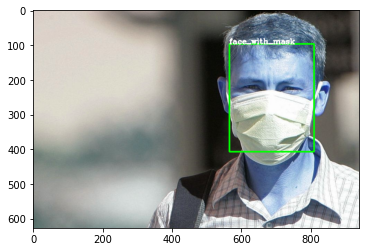

In [ ]:
''' Not Essential '''
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Input
import numpy as np

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.join("/content/drive/My Drive/datasets/facemask/face_detector", "deploy.prototxt")
weightsPath = os.path.join("/content/drive/My Drive/datasets/facemask/face_detector", "res10_300x300_ssd_iter_140000.caffemodel")
net = cv2.dnn.readNet(prototxtPath, weightsPath)

def detect_face(img):
    # img = preprocess_input(img)
    (h, w) = img.shape[:2]

    # construct a blob from the image
    blob = cv2.dnn.blobFromImage(img, 1.0, (300, 300), (104.0, 177.0, 123.0))
    # print("Img Shape:", img.shape, "Blob shape:", blob.shape)

    net.setInput(blob)
    detections = net.forward()
    
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence < 0.50:
            continue

        # compute the (x, y)-coordinates of the bounding box for the object
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        buf = 0
        (startX, startY, endX, endY) = (startX - buf, startY - buf, endX + buf, endY + buf) 
        # ensure the bounding boxes fall within the dimensions of the frame
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

        face = img[startY: endY, startX:endX]
        # face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224), interpolation = cv2.INTER_NEAREST) 
        # face = img_to_array(face)
        # face = preprocess_input(face)

        predictions = model.predict(np.array([face]))
        print(predictions)
        label = labels[np.argmax(predictions)]

        # print(label)
        # print(predictions)
        if label == "face_with_mask":
            cv2.rectangle(img, (startX, startY), (endX, endY), (0,255,0), 3)
        elif label == "face_with_mask_incorrect":
            cv2.rectangle(img, (startX, startY), (endX, endY), (255,0,0), 3)
        else:
            cv2.rectangle(img, (startX, startY), (endX, endY), (255,0,0), 3)

        cv2.putText(img,label,(startX, startY),cv2.FONT_HERSHEY_COMPLEX,0.7,(255,255,255),2)

        # face = np.expand_dims(face, axis=0)
        # face = face[0]
        # plt.imshow(face)
        # plt.show()

    # img = np.array([img]) 
    # predictions = baseModel.predict(img, batch_size=1)
    # print(predictions.shape)
    return img

filepath = "Medical mask/Medical mask/Medical Mask/images/0286.jpg"
img = cv2.imread(filepath)

img = detect_face(img)
plt.imshow(img)
plt.show()

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def record_video(filename='video.mp4'):
  js = Javascript("""
    async function recordVideo() {
      // mashes together the advanced_outputs.ipynb function provided by Colab, 
      // a bunch of stuff from Stack overflow, and some sample code from:
      // https://developer.mozilla.org/en-US/docs/Web/API/MediaStream_Recording_API

      // Optional frames per second argument.
      const options = { mimeType: "video/webm; codecs=vp9" };
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const stopCapture = document.createElement("button");
      capture.textContent = "Start Recording";
      capture.style.background = "green";
      capture.style.color = "white";

      stopCapture.textContent = "Stop Recording";
      stopCapture.style.background = "red";
      stopCapture.style.color = "white";
      div.appendChild(capture);

      const video = document.createElement('video');
      const recordingVid = document.createElement("video");
      video.style.display = 'block';

      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      // create a media recorder instance, which is an object
      // that will let you record what you stream.
      let recorder = new MediaRecorder(stream, options);
      document.body.appendChild(div);
      div.appendChild(video);
      // Video is a media element.  This line here sets the object which serves
      // as the source of the media associated with the HTMLMediaElement
      // Here, we'll set it equal to the stream.
      video.srcObject = stream;
      // We're inside an async function, so this await will fire off the playing
      // of a video. It returns a Promise which is resolved when playback has 
      // been successfully started. Since this is async, the function will be 
      // paused until this has started playing. 
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      // and now, just wait for the capture button to get clicked in order to
      // start recording
      await new Promise((resolve) => {
        capture.onclick = resolve;
      });
      recorder.start();
      capture.replaceWith(stopCapture);
      // use a promise to tell it to stop recording
      await new Promise((resolve) => stopCapture.onclick = resolve);
      recorder.stop();

      let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
      let arrBuff = await recData.data.arrayBuffer();
      
      // stop the stream and remove the video element
      stream.getVideoTracks()[0].stop();
      div.remove();

      let binaryString = "";
      let bytes = new Uint8Array(arrBuff);
      bytes.forEach((byte) => {
        binaryString += String.fromCharCode(byte);
      })
      return btoa(binaryString);
    }
    """)
  try:
    display(js)
    data = eval_js('recordVideo({})')
    binary = b64decode(data)
    with open(filename, "wb") as video_file:
      video_file.write(binary)
    print(
        f"Finished recording video. Saved binary under filename in current working directory: {filename}"
    )
  except Exception as err:
      # In case any exceptions arise
      print(str(err))
  return filename

In [ ]:
# Run the function, get the video path as saved in your notebook, and play it back here.
from IPython.display import HTML
from base64 import b64encode

video_width = 300

video_path = record_video()
video_file = open(video_path, "r+b").read()

video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

In [ ]:
import numpy as np
import cv2

cap = cv2.VideoCapture('video.mp4')

# writer = cv2.VideoWriter("Result.avi", fourcc, 30, (480, 640), True) 
writer = None

while(cap.isOpened()):
    ret, frame = cap.read()
    if frame is None:
        break

    # gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # img = cv2.imread(filepath)
    frame = detect_face(frame)

    # Check if the video writer is None 
    if writer is None: 
        # Initialize our video writer 
        fourcc = cv2.VideoWriter_fourcc(*'MP4V') 
        writer = cv2.VideoWriter("result.mp4", fourcc, 30, (frame.shape[1], frame.shape[0])) 
     
    writer.write(frame) 
writer.release() 
cap.release()

[[0.00257697 0.99742305]]
[[0.00121266 0.99878734]]
[[9.776916e-06 9.999902e-01]]
[[1.4437762e-05 9.9998558e-01]]
[[0.0269427  0.97305727]]
[[0.0012104 0.9987896]]
[[0.0016442 0.9983558]]
[[8.2096329e-04 9.9917907e-01]]
[[0.09449332 0.9055066 ]]
[[2.1436936e-04 9.9978560e-01]]
[[0.00490111 0.9950989 ]]
[[0.00942894 0.990571  ]]
[[0.003961   0.99603903]]
[[0.01121578 0.9887842 ]]
[[0.07320689 0.9267931 ]]
[[0.00147054 0.99852943]]
[[5.339686e-04 9.994660e-01]]
[[1.2388386e-04 9.9987614e-01]]
[[1.5064683e-04 9.9984932e-01]]
[[0.00110144 0.9988985 ]]
[[6.316454e-05 9.999368e-01]]
[[6.7655754e-04 9.9932349e-01]]
[[3.2972870e-04 9.9967027e-01]]
[[1.09406705e-04 9.99890566e-01]]
[[1.3722687e-04 9.9986279e-01]]
[[0.01052115 0.9894789 ]]
[[0.00233471 0.9976653 ]]
[[0.04483387 0.9551661 ]]
[[1.1534688e-05 9.9998844e-01]]
[[0.00231271 0.99768734]]
[[1.5656439e-04 9.9984336e-01]]
[[0.02865156 0.97134846]]
[[0.09858831 0.90141165]]
[[0.08218211 0.91781795]]
[[0.00423158 0.9957684 ]]
[[0.1091809 0.

In [ ]:
video_file = open("result.mp4", "r+b").read()
video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")